In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## systematic test 

In [2]:
import numpy as np

In [3]:
from run_systematics import sys_iteration, fitting_SP, sys_ngal, weightmultiply, fitting_allSP, calling_sysMap, maskingCatalogSP

In [4]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
inputdir = rootdir
basedir = inputdir+'/act/'
figoutdir = inputdir+'/figure/'
sysoutdir = inputdir+'/sys/'
wdir = sysoutdir+'/weights/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+sysoutdir)
os.system('mkdir '+wdir)
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

256

In [5]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [68]:
# import DMASS

#dmass = fitsio.read(rootdir+'spt.fits')
dmass = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v2.fits')
#dmass = dmass[dmass['EachProb_CMASS'] > 0.00]
#dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB'])
print 'dmass sample size :', np.sum(dmass['CMASS_PROB'])


#dmass = cutcat20(dmass)
#dmass_st82 = fitsio.read(rootdir+'dmass_st82_0004.fits')
dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob')
#dmass_st82 = dmass_st82[dmass_st82['CMASS_PROB'] > 0.00]
dmass_st82 = appendColumn(cat = dmass_st82, name='WEIGHT', value=dmass_st82['EachProb_CMASS'])


cmass = fitsio.read(rootdir+'train_sample_des.fits')


#print 'dmass st82 sample size :', np.sum(dmass_st82['CMASS_PROB'])
print 'cmass sample size :', cmass.size


#dmass = appendColumn(cat = dmass, name='CMASS_PROB', value=dmass['EachProb_CMASS'])
#dmass_st82 = appendColumn(cat = dmass_st82, name='WEIGHT', value=dmass_st82['EachProb_CMASS'])
#print np.sum(dmass['EachProb_CMASS']), np.sum(dmass_st82['EachProb_CMASS'])


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v2.fits
dmass sample size : 120874.72753482158

--------------------------------
 calling catalog
--------------------------------
gold_st82_prob.fits
cmass sample size : 12639


In [28]:

random = uniform_random_on_sphere(GoldMask, size = dmass.size/10)
random = Cuts.keepGoodRegion(random)
#rand = Cuts.keepY1GoldRegion(rand)
rand = random[ random['DEC'] < -3.0 ]
rand_st82 = random[ random['DEC'] > -3.0 ]
#rand2 = cutcat20(rand2)


random = uniform_random_on_sphere(GoldMask, size = 50*dmass.size)
random = Cuts.keepGoodRegion(random)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = random[ random['DEC'] < -3.0 ]
rand_st82_2 = random[ random['DEC'] > -3.0 ]
#rand2 = cutcat20(rand2)

print rand.size, rand2.size, dmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)
random = None

42592 21420908 6777228


In [29]:
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap, maskonly=False )

21420908 20990512
mask  0.9799076677795358


In [27]:
print rand.size, rand2.size, dmass.size, rand2_masked.size

42630 8564689 6777228 8392218


In [69]:
suf = 'wg_fwhm_r_airmass_z_exptime_g_fwhm_i_airmass_g_fwhm_g'
orderlabel = suf.split('_')[1:]
order = []
for i in np.arange(0, len(orderlabel), 2):
    order.append( orderlabel[i]+'_'+orderlabel[i+1] )
order = ['vetoed'] + order
print order

weightDic_re = {}
#weightDic_re['vetoed'] = np.ones(dmass.size)  # dmass['EachProb_CMASS']
#hpmask= maskingCatalogSP(catalog=dmass, sysMap=sysMap, maskonly=True )
#weightDic_re['vetoed'][~hpmask] = 0
#fitsio.write(sysoutdir+'weights/wg_vetoed_SPT.fits', weightDic_re['vetoed'], clobber=True)
for o in order : 
    weightDic_re[o] = fitsio.read(sysoutdir+'weights/wg_'+o+'_SPT.fits')
all_weight = weightmultiply(weightDic_re)

['vetoed', 'fwhm_r', 'airmass_z', 'exptime_g', 'fwhm_i', 'airmass_g', 'fwhm_g']
['vetoed', 'fwhm_g', 'airmass_z', 'fwhm_r', 'fwhm_i', 'airmass_g', 'exptime_g']
vetoed
fwhm_g
airmass_z
fwhm_r
fwhm_i
airmass_g
exptime_g


In [114]:
#dmass = appendColumn(cat = dmass, name='VETO', value=weightDic_re['vetoed'])
#dmass = appendColumn(cat = dmass, name='WEIGHT_SYS', value=all_weight)
#dmass = appendColumn(cat = dmass, name='CMASS_PROB', value=dmass['EachProb_CMASS'])

ValueError: field 'CMASS_PROB' occurs more than once

In [70]:
dmass = appendColumn(cat = dmass, name='WEIGHT0_fwhm_r', value=weightDic_re['fwhm_r'])
dmass = appendColumn(cat = dmass, name='WEIGHT1_airmass_z', value=weightDic_re['airmass_z'])
dmass = appendColumn(cat = dmass, name='WEIGHT2_exptime_g', value=weightDic_re['exptime_g'])
dmass = appendColumn(cat = dmass, name='WEIGHT3_fwhm_i', value=weightDic_re['fwhm_i'])
dmass = appendColumn(cat = dmass, name='WEIGHT4_airmass_g', value=weightDic_re['airmass_g'])
dmass = appendColumn(cat = dmass, name='WEIGHT5_fwhm_g', value=weightDic_re['fwhm_g'])


In [71]:
fitsio.write( rootdir+'dmass_spt_sys_v3.fits', dmass, clobber=True )

In [ ]:
dmass.dtype.names

In [31]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap, maskonly=False )
dmass_masked = dmass_masked[dmass_masked['CMASS_PROB'] > 0.01 ]

6777228 6641688
mask  0.9800006728414626


In [32]:
fitsio.write( rootdir+'dmass_spt_sys_v2_masked_pcut01.fits', dmass_masked, clobber=True )

In [30]:
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap, maskonly=False )
fitsio.write( rootdir+'random_x50_dmass_spt_masked.fits', rand2_masked, clobber=True )

21420908 20990512
mask  0.9799076677795358


writing output plot to: ../paper_figure//st82_diagnostic_histograms_1d.pdf


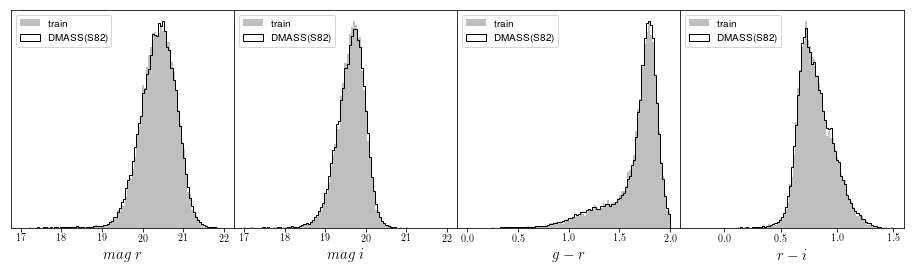

In [28]:
labels = ['$mag~r$', '$mag~i$', '$g-r$', '$r-i$']#, 'i-z']
ranges =  [[17,22], [17, 22], [-0.0,2], [-0.3,1.5]]#, [0.0,0.8]] 

X_train, Xcov_train = mixing_color(cmass, no_zband=False)
X_test, Xcov_test = mixing_color(dmass_st82, no_zband=False)
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges, weight=[None, dmass_st82['EachProb_CMASS']],\
                    name =['train','DMASS(S82)' ], nbins=100, prefix='st82_', outdir='../paper_figure/')

writing output plot to: ../paper_figure//spt_diagnostic_histograms_1d.pdf


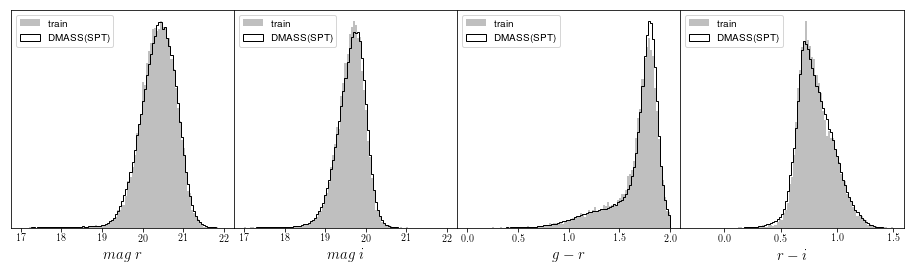

In [29]:
labels = ['$mag~r$', '$mag~i$', '$g-r$', '$r-i$']#, 'i-z']
ranges =  [[17,22], [17, 22], [-0.0,2], [-0.3,1.5]]#, [0.0,0.8]] 

X_train, Xcov_train = mixing_color(cmass, no_zband=False)
X_test, Xcov_test = mixing_color(dmass, no_zband=False)
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,
                    weight=[None, dmass['EachProb_CMASS']],
                    name =['train','DMASS(SPT)' ], nbins=100, prefix='spt_', outdir='../paper_figure/')

In [15]:
kind = 'SPT'
FullArea = SPTMaparea
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM']
#properties = ['GE', 'NSTARS_allband']
#properties = ['FWHM']
suffix='no_weight'
# calculating galaxy density and weights iterately
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [33]:
GoldMask_spt_sys = maskingCatalogSP(catalog=GoldMask_spt, sysMap=sysMap)
print GoldMask_spt.size, GoldMask_spt_sys.size

6153627 6030163
mask  0.9799363854845281
6153627 6030163


In [34]:
fitsio.write(rootdir + 'mask_dmass.fits', GoldMask_spt, clobber=True )
fitsio.write(rootdir + 'mask_dmass_sys.fits', GoldMask_spt_sys, clobber=True)